In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load MovieLens datasets
movies = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/movies.csv")
ratings = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/ratings.csv")
tags = pd.read_csv("/Users/sarahberkin/Documents/DataScience/MovieRecommender/ml-latest-small/tags.csv")

In [7]:
# Display first few rows
print("Movies:\n", movies.head(), "\n")
print("Ratings:\n", ratings.head(), "\n")
print("Tags:\n", tags.head(), "\n")

Movies:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Ratings:
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

Tags:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2  

In [9]:
# Check for missing values
print("Missing values in movies:\n", movies.isnull().sum(), "\n")
print("Missing values in ratings:\n", ratings.isnull().sum(), "\n")
print("Missing values in tags:\n", tags.isnull().sum(), "\n")

Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64 

Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

Missing values in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64 



In [11]:
# Check data types
print("Data types in movies:\n", movies.dtypes, "\n")
print("Data types in ratings:\n", ratings.dtypes, "\n")
print("Data types in tags:\n", tags.dtypes, "\n")

Data types in movies:
 movieId     int64
title      object
genres     object
dtype: object 

Data types in ratings:
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object 

Data types in tags:
 userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object 



In [13]:
#Checking how many ratings are between 1-2 to make sure we can simulate scrolling frustration
low_ratings = ratings[(ratings["rating"] >= 1.0) & (ratings["rating"] <= 2.0)]
low_rating_count = low_ratings.shape[0]
total_ratings_count = ratings.shape[0]
low_rating_percentage = (low_rating_count / total_ratings_count) * 100
print(f"Total Ratings: {total_ratings_count}")
print(f"Low Ratings (1-2): {low_rating_count}")
print(f"Percentage of Low Ratings: {low_rating_percentage:.2f}%")

Total Ratings: 100836
Low Ratings (1-2): 12153
Percentage of Low Ratings: 12.05%


In [15]:
#Checking data sparcity (if very low (<1%), collaborative filtering may struggle)
num_ratings = ratings.shape[0]
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()
total_possible_ratings = num_users * num_movies

sparsity = (num_ratings / total_possible_ratings) * 100
print(f"Data Sparsity: {sparsity:.5f}%")

Data Sparsity: 1.69997%


implicit_feedback
1    61.204332
0    38.795668
Name: proportion, dtype: float64


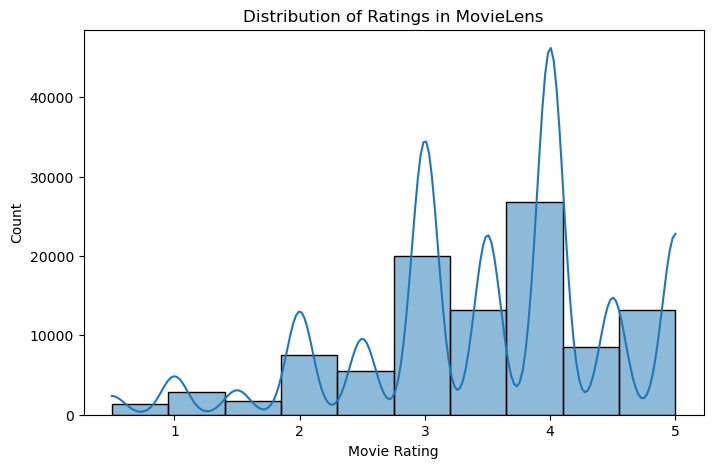

In [17]:
#Checking implicit ratings (if 90%+ feddback is "1", dataset may be unbalanced)
ratings["implicit_feedback"] = ratings["rating"].apply(lambda x: 1 if x >= 3.5 else 0)
print(ratings["implicit_feedback"].value_counts(normalize=True) * 100)

#Visualing rating distribution
plt.figure(figsize=(8,5))
sns.histplot(ratings["rating"], bins=10, kde=True)
plt.xlabel("Movie Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings in MovieLens")
plt.show()

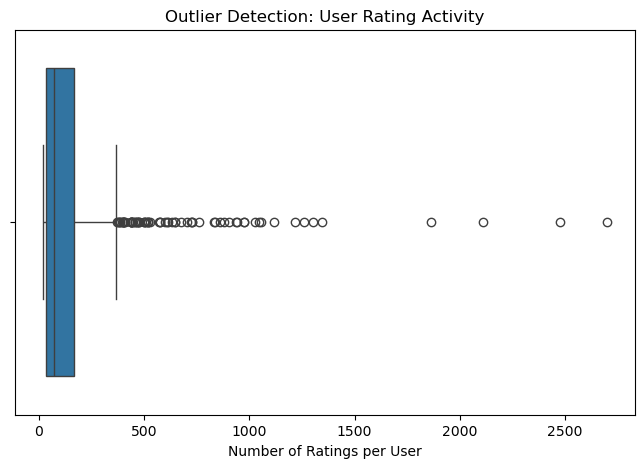

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64


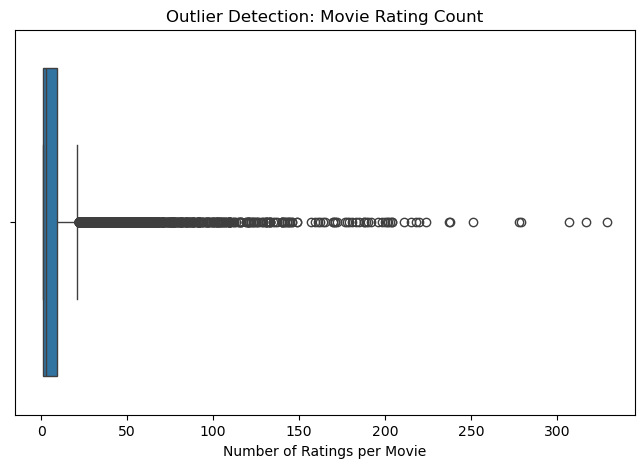

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64


In [19]:
#Outliers

#Number ratings per user
user_rating_counts = ratings["userId"].value_counts()
plt.figure(figsize=(8,5))
sns.boxplot(x=user_rating_counts)
plt.xlabel("Number of Ratings per User")
plt.title("Outlier Detection: User Rating Activity")
plt.show()
print(user_rating_counts.describe())

#Number ratings per movie
movie_rating_counts = ratings["movieId"].value_counts()
plt.figure(figsize=(8,5))
sns.boxplot(x=movie_rating_counts)
plt.xlabel("Number of Ratings per Movie")
plt.title("Outlier Detection: Movie Rating Count")
plt.show()
print(movie_rating_counts.describe())

Upper Outlier Threshold for Extreme Users: 367.5
Upper Outlier Threshold for Exceptionally Popular Movies: 21.0


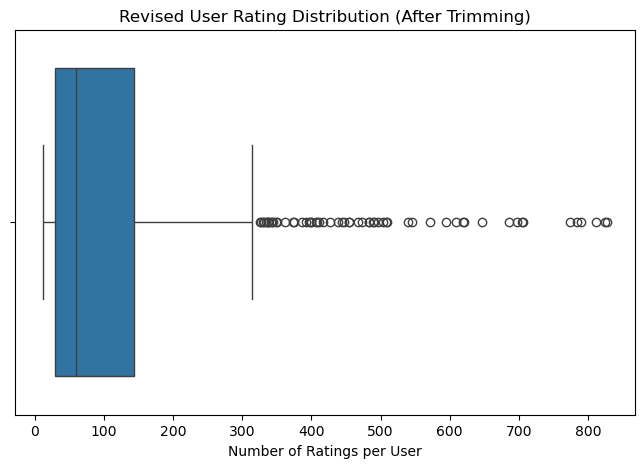

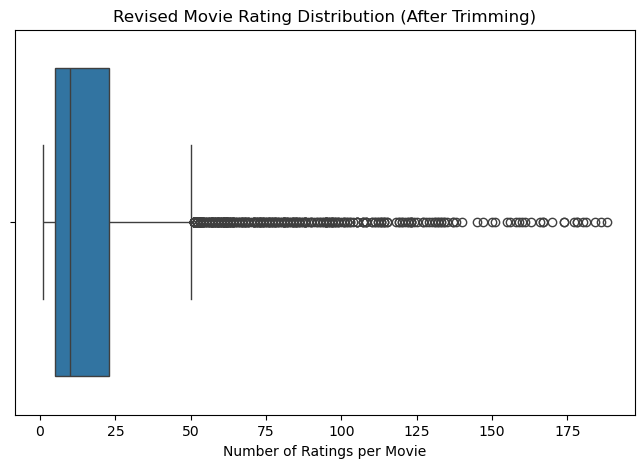

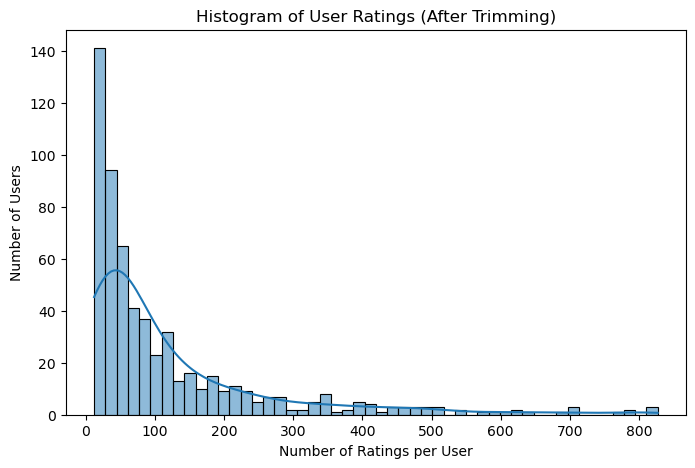

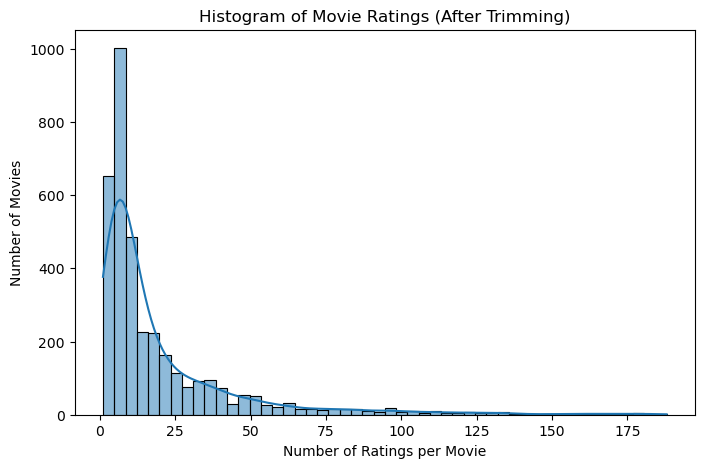

In [21]:
#Further look into outliers

#Number ratings per user IQR
Q1 = user_rating_counts.quantile(0.25)  # 25th percentile (35 ratings)
Q3 = user_rating_counts.quantile(0.75)  # 75th percentile (168 ratings)
IQR = Q3 - Q1

# Define upper limit for extreme users
upper_limit = Q3 + 1.5 * IQR
print(f"Upper Outlier Threshold for Extreme Users: {upper_limit}")

#Moderate trimming
filtered_users = user_rating_counts[user_rating_counts <= 1000].index
ratings_filtered = ratings[ratings["userId"].isin(filtered_users)]

#Number ratings per movie IQR
Q1_movies = movie_rating_counts.quantile(0.25)  # 1 rating
Q3_movies = movie_rating_counts.quantile(0.75)  # 9 ratings
IQR_movies = Q3_movies - Q1_movies 

# Define upper bound for outliers
upper_limit_movies = Q3_movies + 1.5 * IQR_movies
print(f"Upper Outlier Threshold for Exceptionally Popular Movies: {upper_limit_movies}")

#Moderate trimming
filtered_movies = movie_rating_counts[(movie_rating_counts >= 5) & (movie_rating_counts <= 200)].index
ratings_filtered = ratings_filtered[ratings_filtered["movieId"].isin(filtered_movies)]

#Revised visualizations
plt.figure(figsize=(8,5))
sns.boxplot(x=ratings_filtered["userId"].value_counts())
plt.xlabel("Number of Ratings per User")
plt.title("Revised User Rating Distribution (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=ratings_filtered["movieId"].value_counts())
plt.xlabel("Number of Ratings per Movie")
plt.title("Revised Movie Rating Distribution (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(ratings_filtered["userId"].value_counts(), bins=50, kde=True)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.title("Histogram of User Ratings (After Trimming)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(ratings_filtered["movieId"].value_counts(), bins=50, kde=True)
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Number of Movies")
plt.title("Histogram of Movie Ratings (After Trimming)")
plt.show()

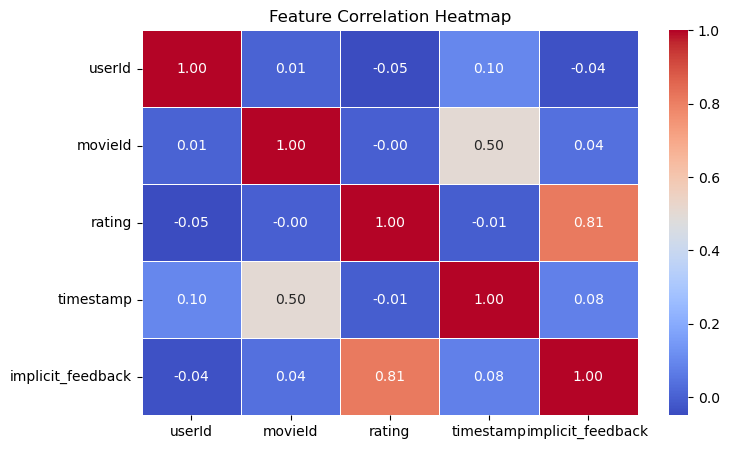

In [23]:
#Feature correlation Heatmap to see if feedback strongly correlates with ratings
correlation_matrix = ratings.corr()
plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

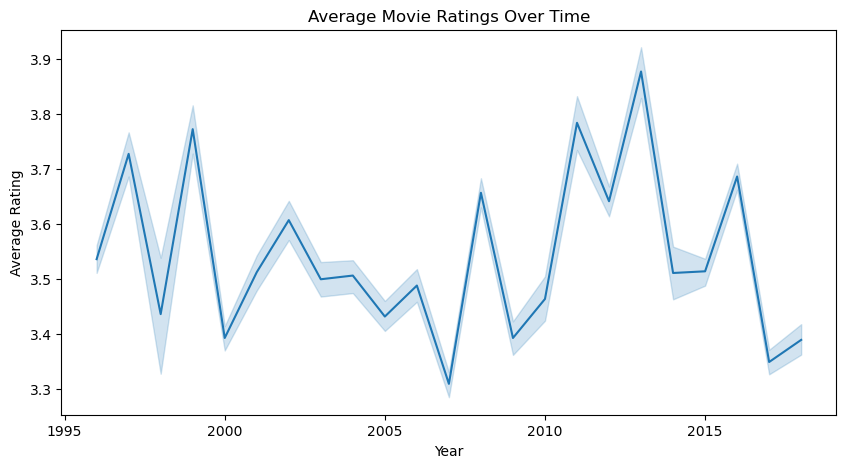

In [25]:
#Check if ratings are changing over time, older vs newer movies
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings["rating_year"] = ratings["timestamp"].dt.year
plt.figure(figsize=(10,5))
sns.lineplot(x="rating_year", y="rating", data=ratings, estimator="mean")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Movie Ratings Over Time")
plt.show()

In [27]:
import re

# Extract year from the title (if not already done)
def extract_year(title):
    match = re.search(r"\((\d{4})\)", title)
    return int(match.group(1)) if match else None

movies["year"] = movies["title"].apply(extract_year)

In [29]:
# One-hot encode genres
genre_dummies = movies["genres"].str.get_dummies(sep="|")

# Merge with original movies DataFrame
movies = pd.concat([movies, genre_dummies], axis=1)

In [31]:
# Merge trimmed ratings with movie metadata
ratings_merged = ratings_filtered.merge(movies, on="movieId", how="inner")

# Preview
print(ratings_merged.head())

   userId  movieId  rating  timestamp  implicit_feedback  \
0       1        3     4.0  964981247                  1   
1       1        6     4.0  964982224                  1   
2       1       70     3.0  964982400                  0   
3       1      101     5.0  964980868                  1   
4       1      151     5.0  964984041                  1   

                        title                          genres    year  \
0     Grumpier Old Men (1995)                  Comedy|Romance  1995.0   
1                 Heat (1995)           Action|Crime|Thriller  1995.0   
2  From Dusk Till Dawn (1996)   Action|Comedy|Horror|Thriller  1996.0   
3        Bottle Rocket (1996)  Adventure|Comedy|Crime|Romance  1996.0   
4              Rob Roy (1995)        Action|Drama|Romance|War  1995.0   

   (no genres listed)  Action  ...  Film-Noir  Horror  IMAX  Musical  Mystery  \
0                   0       0  ...          0       0     0        0        0   
1                   0       1  ...    

In [33]:
# Center ratings around the user's average to eliminate bias

# Calculate mean rating per user
user_mean_ratings = ratings_merged.groupby("userId")["rating"].mean()

# Subtract mean rating to normalize
ratings_merged["rating_normalized"] = ratings_merged.apply(
    lambda row: row["rating"] - user_mean_ratings[row["userId"]],
    axis=1
)

In [35]:
# Pivot to create user-item rating matrix
user_item_matrix = ratings_merged.pivot_table(index="userId", columns="movieId", values="rating")

# Check shape
print("User-Item Matrix shape:", user_item_matrix.shape)

User-Item Matrix shape: (598, 3632)


In [37]:
# To power content-based filtering, convert user-generated tags into TF-IDF vectors

from sklearn.feature_extraction.text import TfidfVectorizer

# Merge tags into one string per movie
tags_grouped = tags.groupby("movieId")["tag"].apply(lambda x: " ".join(x)).reset_index()

# Join with movie metadata
movies_with_tags = movies.merge(tags_grouped, on="movieId", how="left")
movies_with_tags["tag"].fillna("", inplace=True)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(movies_with_tags["tag"])

# Check shape
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

TF-IDF Matrix shape: (9742, 1673)


In [39]:
# Move to Modeling steps
# Prepare data for Surprise (Collaborative filtering)

from surprise import Dataset, Reader

# Use only the columns Surprise expects
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_filtered[["userId", "movieId", "rating"]], reader)

In [41]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [43]:
from surprise import SVD
from surprise import accuracy

# Initialize and train the model
svd_model = SVD()
svd_model.fit(trainset)

# Predict on test set
predictions = svd_model.test(testset)

# Evaluate performance
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.9037
RMSE: 0.9037


In [45]:
from collections import defaultdict

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Sort and grab top N for each user
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

# Example: print top 5 movieIds recommended for the first user
print(top_n[list(top_n.keys())[0]])

[(1197, 4.095398336058154), (2028, 4.015344872235762), (3147, 3.9842634365086096), (49272, 3.9463672623242196), (68157, 3.9442144311535148)]


In [47]:
# Prepare for Cosine Similarity + TF-IDF (Content-based filtering)

from sklearn.metrics.pairwise import cosine_similarity

# tfidf_matrix from earlier step (already computed from tags)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [49]:
# Reset index to use movieId as reference
movie_indices = pd.Series(movies_with_tags.index, index=movies_with_tags['title']).drop_duplicates()

In [51]:
def get_similar_movies(title, n=5):
    idx = movie_indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    movie_indices_list = [i[0] for i in sim_scores]
    return movies_with_tags['title'].iloc[movie_indices_list]

# Example usage
print(get_similar_movies("Toy Story (1995)", n=5))

1757                Bug's Life, A (1998)
2355                  Toy Story 2 (1999)
8695    Guardians of the Galaxy 2 (2017)
7039                           Up (2009)
8546                   Big Hero 6 (2014)
Name: title, dtype: object


In [53]:
# Introduce in 2nd type of model for comparison, KNN Collaborative Filtering

from surprise import KNNBasic

# Set similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False  # Set to False for item-based filtering
}

# Initialize KNN model
knn_model = KNNBasic(sim_options=sim_options)

# Train on the training set
knn_model.fit(trainset)

# Predict on the test set
knn_predictions = knn_model.test(testset)

# Evaluate
from surprise import accuracy
knn_rmse = accuracy.rmse(knn_predictions)
print(f"KNN Model RMSE: {knn_rmse:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9819
KNN Model RMSE: 0.9819


In [55]:
# Introduce in 2nd type of model for comparison, Regression Model (Random Forest)

# Get number of ratings per movie (popularity)
movie_rating_counts = ratings_filtered.groupby("movieId")["rating"].count().reset_index()
movie_rating_counts.columns = ["movieId", "num_ratings"]

# Get average rating per movie
movie_avg_ratings = ratings_filtered.groupby("movieId")["rating"].mean().reset_index()
movie_avg_ratings.columns = ["movieId", "avg_movie_rating"]

# Get average rating per user
user_avg_ratings = ratings_filtered.groupby("userId")["rating"].mean().reset_index()
user_avg_ratings.columns = ["userId", "avg_user_rating"]

# Merge all features
features_df = ratings_filtered.merge(movies, on="movieId", how="left")
features_df = features_df.merge(movie_rating_counts, on="movieId", how="left")
features_df = features_df.merge(movie_avg_ratings, on="movieId", how="left")
features_df = features_df.merge(user_avg_ratings, on="userId", how="left")

# Drop unused columns
features_df = features_df.drop(columns=["genres", "tag"], errors="ignore")

# Keep only the genre dummies and numeric columns
feature_cols = ["year", "num_ratings", "avg_movie_rating", "avg_user_rating"] + list(genre_dummies.columns)
features_df = features_df.dropna(subset=feature_cols + ["rating"])  # drop any rows with missing values

In [57]:
X = features_df[feature_cols]
y = features_df["rating"]

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print(f"Random Forest RMSE: {rmse_rf:.4f}")

Random Forest RMSE: 0.8806


In [62]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Set up the Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=1,
                           verbose=1)

# Fit
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_best = best_rf.predict(X_test)
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
print(f"Tuned Random Forest RMSE: {best_rmse:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest RMSE: 0.8332


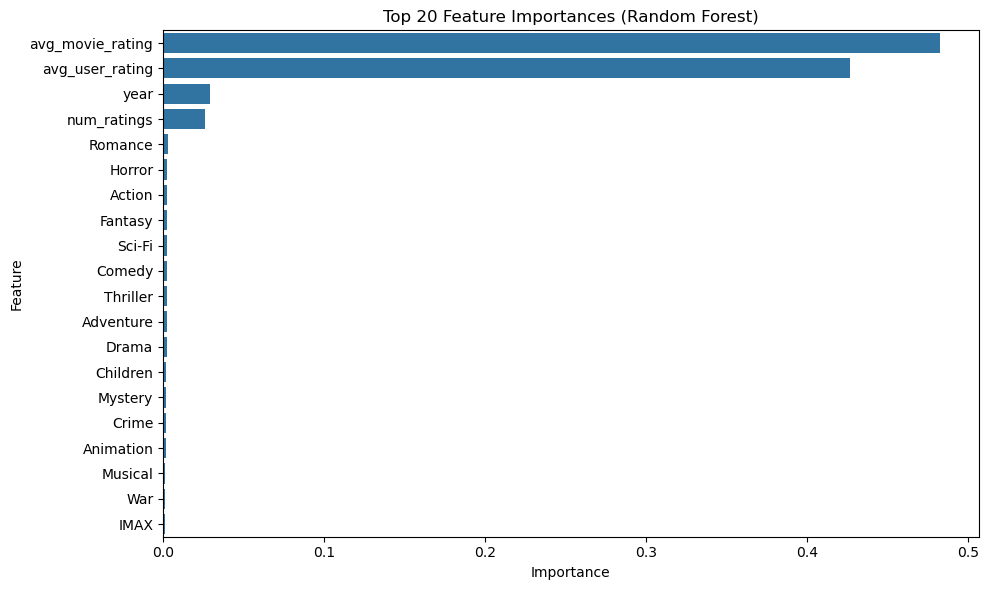

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from best model
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame with feature importances (top 20 only)
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort & reduce to top 20 before plotting
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

In [68]:
print(rmse, knn_rmse, best_rmse)

0.9037312833653662 0.9819263878633143 0.8332240338566065


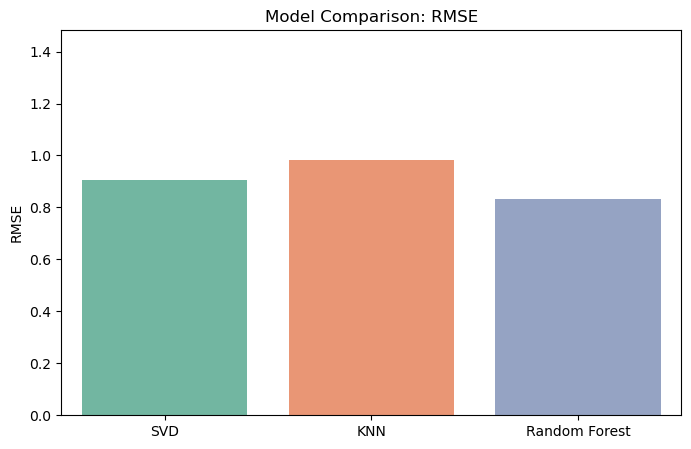

In [70]:
# Collect RMSEs 
model_names = ["SVD", "KNN", "Random Forest"]
rmse_values = [rmse, knn_rmse, best_rmse]  

# Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=rmse_values, palette="Set2")
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE")
plt.ylim(0, max(rmse_values) + 0.5)
plt.show()

In [72]:
# Can we reduce scroll time? 

# Select a user with a decent number of ratings
example_user = ratings_filtered["userId"].value_counts().idxmax()

# Get all their past ratings
user_history = ratings_filtered[ratings_filtered["userId"] == example_user]
user_history = user_history.sort_values(by="rating", ascending=True)  # simulate scrolling from bad to good

# Count how many low ratings (1–2) before a high one (≥4)
bad_before_good = 0
found_good = False

for rating in user_history["rating"]:
    if rating >= 4:
        found_good = True
        break
    else:
        bad_before_good += 1

print(f"User {example_user} gave {bad_before_good} low ratings before finding something they liked (≥4).")

User 298 gave 758 low ratings before finding something they liked (≥4).


In [74]:
# Predict top N recommendations for the same user using SVD
from surprise import Dataset, Reader
from surprise import SVD

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_filtered[["userId", "movieId", "rating"]], reader)
trainset = data.build_full_trainset()
svd_model = SVD().fit(trainset)

# Get all movies the user hasn’t rated
all_movie_ids = ratings_filtered["movieId"].unique()
rated_movie_ids = user_history["movieId"].unique()
unseen_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

# Predict ratings for unseen movies
predictions = [svd_model.predict(uid=example_user, iid=mid) for mid in unseen_movie_ids]
top_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

# Simulate how many of the top 10 are predicted to be ≥4
good_recs = [p for p in top_preds if p.est >= 4.0]
print(f"Model predicted {len(good_recs)} out of top 10 recommendations would be rated ≥ 4 by the user.")

Model predicted 0 out of top 10 recommendations would be rated ≥ 4 by the user.


In [76]:
# Try a different user with fewer total ratings, or more high ratings
user_ratings_summary = ratings_filtered.groupby("userId")["rating"].agg(["count", "mean"])
user_ratings_summary = user_ratings_summary.sort_values(by="mean", ascending=False)

# Pick a user with high mean rating
easier_user = user_ratings_summary[user_ratings_summary["count"] > 50].head(1).index[0]
print(f"Try this user next: {easier_user}")

Try this user next: 523


In [78]:
# Simulate user scrolling through content they've rated
example_user = 523

# Get their actual rating history
user_history = ratings_filtered[ratings_filtered["userId"] == example_user]
user_history = user_history.sort_values(by="rating", ascending=True)

# Count how many low ratings (1–2) before a high one (≥4)
bad_before_good = 0
found_good = False

for rating in user_history["rating"]:
    if rating >= 4:
        found_good = True
        break
    else:
        bad_before_good += 1

print(f"User {example_user} gave {bad_before_good} low ratings before finding something they liked (≥4).")

User 523 gave 3 low ratings before finding something they liked (≥4).


In [80]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Prepare data for Surprise (if not already done)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_filtered[["userId", "movieId", "rating"]], reader)
trainset = data.build_full_trainset()

# Train SVD model
svd_model = SVD().fit(trainset)

# Get all movies the user hasn’t rated
all_movie_ids = ratings_filtered["movieId"].unique()
rated_movie_ids = user_history["movieId"].unique()
unseen_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

# Predict ratings for unseen movies
predictions = [svd_model.predict(uid=example_user, iid=mid) for mid in unseen_movie_ids]
top_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

# Check how many predicted ratings are ≥4
good_recs = [p for p in top_preds if p.est >= 4.0]
print(f"Model predicted {len(good_recs)} out of top 10 recommendations would be rated ≥ 4 by the user.")

Model predicted 10 out of top 10 recommendations would be rated ≥ 4 by the user.
